# Hackathon #2

Written by Eleanor Quint

Topics: 
- Dense layers
- Gradient descent optimization
- Training by minibatch/gradient step and epoch
- TensorBoard

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [1]:
# We'll start with our library imports...
from __future__ import print_function

import tensorflow as tf         # to specify and run computation graphs
import numpy as np              # for numerical operations taking place outside of the TF graph
import matplotlib.pyplot as plt # to draw plots

mnist_dir = '/work/cse496dl/shared/hackathon/02/mnist/'

### A First Attempt at Classifying MNIST

MNIST is a dataset of greyscale `28x28` handwritten digits labelled 1 through 9. We'll use it for a 10-class problem to learn the basics of classification.

Let's have a look at the data first. We load the data from `numpy` save files using `np.load` and can visualize it with matplotlib's `plt.imshow`. The images (shape `[28,28]`) are flat when we first load them (shape `[784]`), so we'll have to [np.reshape](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.reshape.html) any images we want to visualize. The labels are "one-hot", or arrays of length equal to the number of classes (in this case, 10) with the `n`-th entry set to 1 and the rest to 0, indicating the integer value `n`.

In [2]:
# load our dataset, MNIST
train_images = np.load(mnist_dir + 'mnist_train_images.npy')
print("Train image tensor shape: " + str(train_images.shape))

train_labels = np.load(mnist_dir + 'mnist_train_labels.npy')
print("Train label tensor shape: " + str(train_labels.shape))

test_images = np.load(mnist_dir + 'mnist_test_images.npy')
print("Test image tensor shape: " + str(test_images.shape))

test_labels = np.load(mnist_dir + 'mnist_test_labels.npy')
print("Test label tensor shape: " + str(test_labels.shape))

Train image tensor shape: (55000, 784)
Train label tensor shape: (55000, 10)
Test image tensor shape: (10000, 784)
Test label tensor shape: (10000, 10)


A label looks like this: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
And an image looks like this:


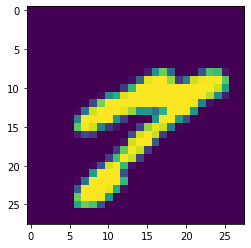

In [3]:
# visualize some of the data
idx = np.random.randint(train_images.shape[0])
print("A label looks like this: " + str(train_labels[idx]))
print("And an image looks like this:")
imgplot = plt.imshow(train_images[idx].reshape((28,28)))

The first step to building a simple neural network is to specify layers. The most basic building block is the dense layer (AKA linear layer or fully connected layer), so we'll declare a function that creates the layer. Each dense layer is composed of two variables, the weight matrix `W` and the bias vector `b` as well as a non-linear activation function `a`, to calculate the function `f(x) = a(Wx + b)`.

In [4]:
def dense_layer(x, output_size, activation=tf.identity, name='dense'):
    """
    Args:
        - x: a rank two tensor, [batch_size, data_size]
        - output_size: (int) number of neurons
        - activation: non-linear function applied to the output
        - name: TensorFlow name scope for variable
    Returns:
        a rank two tensor with shape [batch_size, output_size]
    """
    
    # If we used tf.get_variable it will use existing variable with provided parameters, and create a new one 
    # only if it does not already exist
    
    # tf.Variable will always create a new variable
    
    # Output will be dense/weights:0 (as example output)
    with tf.name_scope(name) as scope:
        (_, data_size) = x.get_shape().as_list() # Automatically find shape and makes it the correct shape for tensor
        W = tf.Variable(tf.truncated_normal([data_size, output_size]), name='weights')
        b = tf.Variable(tf.truncated_normal([output_size]), name='bias')
        # Runs multiplication + bias through provided activation function
        return activation(tf.matmul(x, W) + b)

The first dimension of the input is reserved to be the "batch" dimension, which allows us to run many data through the model simultaneously. The matrix `W` has a row for each input dimension so that each column corresponds to the weights of one linear unit of the layer. After adding the bias vector to the vector resulting from the vector-matrix multiplication, we activate with a non-linearity or the identity function (the latter if we just want to use a linear transformation). [tf.name_scope](https://www.tensorflow.org/api_docs/python/tf/name_scope) is used to group the layer's parameters in TensorFlow's namespace, and its effects can be seen in TensorBoard.

TensorFlow variables, which host the model parameters persistently in the graph, are declared with [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable), needing only an initial value to be created. You can also name the variable or set it to be untrainable using optional arguments, but a `Variable` is trainable by default. We use [tf.truncated_normal](https://www.tensorflow.org/api_docs/python/tf/truncated_normal) to provide initial values here to keep it simple, even though there are much better initialization schemes (just make sure you never use a constant, e.g., [tf.zeros](https://www.tensorflow.org/api_docs/python/tf/zeros)).

Let's define a simple, two layer network with this function. We activate the first layer with the rectified linear function ([tf.nn.relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu)) and the second layer with [tf.nn.softmax](https://www.tensorflow.org/versions/master/api_docs/python/tf/nn/softmax) so that we can interpret its output as the parameters of a discrete probability distribution.

In [5]:
# Placeholder for input layer, None so batch size is variable
# Dense layers only handle flat data, images will not work
x = tf.placeholder(tf.float32, [None, 784], name='data')

# use a single name scope for the model
# Names becomes MLPM/dense/weights:0 (for example)
with tf.name_scope('multi_layer_perceptron_model') as scope:
    hidden = dense_layer(x, 200, activation=tf.nn.relu, name='hidden_layer')
    output = dense_layer(hidden, 10, activation=tf.nn.softmax, name='output_layer')
    
# Useful for visualizing network in tensorboard
tf.summary.FileWriter("./hackathon2_logs", tf.get_default_graph()).close()

In the last line, we log what we just defined with TensorBoard for visualization. We use [tf.get_default_graph](https://www.tensorflow.org/api_docs/python/tf/get_default_graph) to retrieve a handle to the TF graph that we're working in (the default because we haven't specified a particular graph), and then we write a summary of the graph with [tf.summary.FileWriter](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter). This puts an events file in the "logs" directory which maybe opened with TensorBoard. Access by running `tensorboard --logdir=./logs` and pointing a browser at http://localhost:6006. Information on how to do this on Crane can be found on Piazza.

Note that, though the number of units in the hidden layer may be chosen freely as a hyperparameter, the number of units in the output layer must equal the number of classes in the classification problem. This allows us to use the output as a categorical distribution over the classes, representing the probability that the input belongs to each class.

To summarize how the model is performing in its classification task, let's add a placeholder for the correct output and calculate the [cross-entropy](https://stackoverflow.com/a/41990932) loss between the estimated and correct discrete distributions (i.e., between the model's softmaxed distribution and a distribution with a probability of 1 in the correct class, a one hot vector). We use `EPSILON` to avoid potentially trying to calculate `log(0)`, which is undefined.

In [6]:
# Second placeholder for labels (holds correct labels)
y = tf.placeholder(tf.float32, [None, 10], name='correct_label')

# Calculate cross-entropy for calculation
# Larger value worse network is doing
EPSILON = 1e-10
with tf.name_scope('cross_entropy') as scope:
    # Epsilon only to avoid evaluating log(0) which of course breaks
    cross_entropy = -tf.reduce_sum(output * tf.log(y + EPSILON), axis=1)
    
tf.summary.FileWriter("./hackathon2_logs", tf.get_default_graph()).close()

Now that we've constructed the TF graph, we'll create a session, initialize all variables, and run through an epoch of the test set to plot a histogram of the cross-entropy loss. (One epoch is an iteration of minibatches such that each datum is seen once. Minibatches are also frequently referred to as "batches", as below)

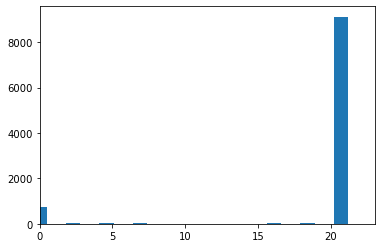

In [7]:
# calculate values of interest to minibatching and epoch calculation
# batch_size is adjustable
train_num_examples = train_images.shape[0]
test_num_examples = test_images.shape[0]
batch_size = 32

# finalize the graph
with tf.Session() as session:
    # Grabs all variables and resets them
    session.run(tf.global_variables_initializer())
    loss_vals = []
    
    # Just one epoch
    
    # Note we did not explicitly call the dense layer we built, but cross-entropy calls output, which calls...
    # loop through each test datum once, saving the cross entropy
    for i in range(test_num_examples // batch_size):
        batch_xs = test_images[i*batch_size:(i+1)*batch_size, :]
        batch_ys = test_labels[i*batch_size:(i+1)*batch_size, :]
        ce_val = session.run(cross_entropy, {x: batch_xs, y: batch_ys})
        loss_vals.append(ce_val)

# now plot per-datum losses
loss_vals = np.concatenate(loss_vals)
hist, bin_edges = np.histogram(loss_vals)
plt.bar(bin_edges[:-1], hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()

It looks like the model guesses the correct class (corresponding to near-zero loss, the smaller bar on the left) on about 10% of the data, which we would have anticipated for a naive model in a 10 class problem. We can improve this model. Let's try this again, this time training with an optimizer.

### A Second Attempt...


In [8]:
# Note that above there was no optimizer

# Clear the graph so we can re-use it. If this is omitted, we get an error.
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 784], name='data')
# use a single name scope for the model
with tf.name_scope('linear_model') as scope:
    # Same as above, but now using tensorflow's defined dense layers
    hidden = tf.layers.dense(x, 200, activation=tf.nn.relu, name='hidden_layer')
    output = tf.layers.dense(hidden, 10, name='output_layer')

W0914 14:51:08.800800 47828886352000 deprecation.py:323] From <ipython-input-8-198f5d0b52d2>:9: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0914 14:51:08.807888 47828886352000 deprecation.py:506] From /util/opt/anaconda/deployed-conda-envs/packages/tensorflow/envs/tensorflow-1.14.0-py36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


This time, we're using [tf.layers.dense](https://www.tensorflow.org/api_docs/python/tf/layers/dense), which has a very similar API to our custom function, but much more functionality.

Further, instead of using a custom cross-entropy function, which has lots of potential for [numerical instability](https://github.com/tensorflow/tensorflow/issues/2462#issuecomment-220842098), we'll use TF's built in function, [tf.nn.softmax_cross_entropy_with_logits_v2](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2). It combines the `softmax` activation of the final layer with the cross-entropy calculation.

In [9]:
# define classification loss
y = tf.placeholder(tf.float32, [None, 10], name='label')
# Use built-in function to calculate cross-entroy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=output)

Now, using the loss tensor, we'll define an optimizer that uses backpropagation to update the values of each layer's variables.

In [10]:
# setup optimizer and training operation
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(cross_entropy)
tf.summary.FileWriter("./hackathon2_logs", tf.get_default_graph()).close()

Here we've chosen the [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer#minimize) optimizer (usually a safe first choice on any given problem), and use the [minimize](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer#minimize) function which is defined for every TensorFlow optimizer. It returns an operation that automatically calculates the gradient of the provided function, and updates all variables marked trainable. We'll pass it to `sess.run` to train for one epoch and then check the test loss values again.

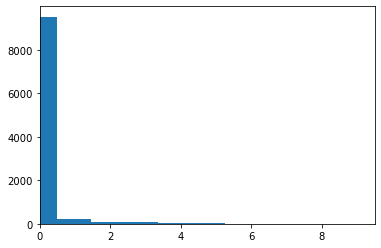

In [11]:

batch_size = 32
session = tf.Session()
session.run(tf.global_variables_initializer())

# train for one epoch
for i in range(train_num_examples // batch_size):
    batch_xs = train_images[i*batch_size:(i+1)*batch_size, :]
    batch_ys = train_labels[i*batch_size:(i+1)*batch_size, :]       
    session.run(train_op, {x: batch_xs, y: batch_ys})

# loop through each test datum once
loss_vals = []
for i in range(test_num_examples // batch_size):
    batch_xs = test_images[i*batch_size:(i+1)*batch_size, :]
    batch_ys = test_labels[i*batch_size:(i+1)*batch_size, :]
    ce_val = session.run(cross_entropy, {x: batch_xs, y: batch_ys})
    loss_vals.append(ce_val)

# now plot per-datum losses
loss_vals = np.concatenate(loss_vals)
hist, bin_edges = np.histogram(loss_vals)
plt.bar(bin_edges[:-1], hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()

Just one training epoch has dramatically improved the model's performance. But on how many of the instances is it actually guessing the correct label?

## Hackathon 2 Exercise 1

Write code to calculate the maximum aposteriori (MAP) estimate of the model on the test data, and compare to the true labels to calculate a confusion matrix with [tf.confusion_matrix](https://www.tensorflow.org/api_docs/python/tf/confusion_matrix). (For the inexperienced, [what is a confusion matrix?](https://en.wikipedia.org/wiki/Confusion_matrix))

(Hint #0: Re-use and modify my code from above. Try not to reinvent the wheel, but always remember to cite borrowed code.)

(Hint #1: The MAP estimate is just the class whose probability is greatest. I reccomend using [tf.argmax](https://www.tensorflow.org/versions/master/api_docs/python/tf/argmax) with the correct `axis` argument to find this to find the max over the correct dimension of the output.)

(Hint #2: tf.confusion_matrix is a function that needs be run in a `session.run` call that returns matrices. Store the resulting matrices in a list and then sum to get the matrix for the full test dataset. Remember to specify the `num_classes` argument.)

In [20]:
# Your code here

# This should only take a few lines of code (hint from hackethon lecture)

# Note that above there was no optimizer

# Clear the graph so we can re-use it. If this is omitted, we get an error.
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 784], name='data')
# use a single name scope for the model
with tf.name_scope('linear_model') as scope:
    # Same as above, but now using tensorflow's defined dense layers
    hidden = tf.layers.dense(x, 200, activation=tf.nn.relu, name='hidden_layer')
    output = tf.layers.dense(hidden, 10, name='output_layer')

In [21]:
# define classification loss
y = tf.placeholder(tf.float32, [None, 10], name='label')
# Use built-in function to calculate cross-entroy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=output)

In [22]:
# setup optimizer and training operation
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(cross_entropy)
tf.summary.FileWriter("./hackathon2_logs", tf.get_default_graph()).close()

In [23]:
# Your code here
#Using code above we will generate the predicted labels
batch_size = 32
session = tf.Session()
session.run(tf.global_variables_initializer())
predicted_class = np.zeros(shape=len(test_labels), dtype=np.int)

for i in range(train_num_examples // batch_size):
    batch_xs = train_images[i*batch_size:(i+1)*batch_size, :]
    batch_ys = train_labels[i*batch_size:(i+1)*batch_size, :]       
    session.run(train_op, {x: batch_xs, y: batch_ys})

# loop through each test datum once

for i in range(test_num_examples // batch_size):
    batch_xs = test_images[i*batch_size:(i+1)*batch_size, :]
    batch_ys = test_labels[i*batch_size:(i+1)*batch_size, :]
    predicted_class[i*batch_size:(i+1)*batch_size] = session.run(tf.argmax(output,1), {x: batch_xs, y: batch_ys})

In [24]:
index = np.argmax(test_labels, axis=1)
num_classes=10
confusion = tf.confusion_matrix(labels=index, predictions=predicted_class, num_classes=num_classes)

In [25]:
sess = tf.Session()
with sess.as_default():
    print(sess.run(confusion))

[[ 970    0    0    1    1    3    1    2    2    0]
 [   2 1126    2    1    0    1    1    0    2    0]
 [   9    7  970    7   10    1    3    8   17    0]
 [   2    1    5  937    3   43    0    6    9    4]
 [   3    0    5    0  959    0    6    0    3    6]
 [   4    1    0    3    4  874    2    0    2    2]
 [  18    4    1    0    9   39  881    0    6    0]
 [   3   15   13    5    5    0    0  968    3   16]
 [   4    4    3   14   10   15    1    4  915    4]
 [   6    8    0    7   24    7    1    5    5  946]]


## Coda

### Saving and Loading TF models

https://www.tensorflow.org/programmers_guide/saved_model, but we'll also discuss this next time.

### Numpy Broadcasting

TensorFlow uses [Numpy broadcasting](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html) when doing arithmetic with arrays of different shapes.

E.g.,

In [18]:
print("scalar-matrix addition")
print(np.ones([2,3]) + 1)
print("matrix-vector addition")
print(np.ones([2,3]) + np.arange(3))
print("broadcasting matrix-vector multiplication")
print((np.ones([2,3])*2) * np.arange(3))
print("proper matrix-vector dot product")
print(np.dot(np.ones([2,3])*2, np.arange(3)))

scalar-matrix addition
[[2. 2. 2.]
 [2. 2. 2.]]
matrix-vector addition
[[1. 2. 3.]
 [1. 2. 3.]]
broadcasting matrix-vector multiplication
[[0. 2. 4.]
 [0. 2. 4.]]
proper matrix-vector dot product
[6. 6.]


### The importance of non-linearities

In [19]:
from IPython.display import HTML
# From Colah's Blog, linearly separating spirals with linear transforms and non-linearities
# see http://colah.github.io/posts/2014-03-NN-Manifolds-Topology
HTML('<img src="http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/img/spiral.1-2.2-2-2-2-2-2.gif">')